# Flood Observatory - GRACE Analysis

<h3> 
Aaron Trefler <br/>
JPL <br/>
Created: 06/07/2016 <br/>
</h3>

# Setup

In [118]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio 

In [119]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [120]:
# define directories
dir_flood = '../../Raw Data/Flood Observatory/'
dir_grace = '../../Work_Matlab/Data/'
dir_figures = '../Figures/'

## Load Data

### Flood Observatory

In [121]:
df_flood = pd.read_csv(dir_flood + 'MasterListrev.csv')

In [122]:
# flood observatory column descriptions
list(df_flood.columns.values)

['Register #',
 'Annual DFO # (discontinued)',
 'Glide #',
 'Country',
 'Other',
 'Nations',
 ' Affected',
 'Detailed Locations (click on active links to access inundation extents)',
 'Validation (post event #3503)',
 'Began',
 'Ended',
 'Duration in Days',
 'Dead',
 'Displaced',
 'Damage (USD)',
 'Main cause',
 'Severity *',
 'Affected sq km',
 'Magnitude (M)**',
 'Centroid X',
 'Centroid Y',
 '"News" if validated',
 'M>6',
 'Total annual floods M>6',
 'M>4',
 'Total annual floods M>4',
 'Date Began',
 'Total floods M>6',
 'Total floods M>4',
 'Notes and Comments (may include quoted headlines from copyrighted news stories; for internal research purposes only)',
 'Unnamed: 30',
 'Unnamed: 31',
 'Unnamed: 32',
 'Unnamed: 33',
 'Unnamed: 34',
 'Unnamed: 35']

### GRACE Mascon-CRI

In [140]:
# GRACE MASCON-CRI Matlab files
mat_content_grace = sio.loadmat(dir_grace + \
    'GRCTellus.JPL.200204_201603.GLO.RL05M_1.MSCNv02CRIv02.nc.mat')
mat_content_derivedMaps = sio.loadmat(dir_grace + \
    'GRCTellus.JPL.200204_201603.GLO.RL05M_1.MSCNv02CRIv02_derivedMaps.nc.mat')
mat_content_dateVectors = sio.loadmat(dir_grace + \
    'GRCTellus.JPL.200204_201603.GLO.RL05M_1.MSCNv02CRIv02_dateVectors.nc.mat')

grace_lwe_perc_adj = mat_content_derivedMaps['lwe_thickness_percentiles_adj']
grace_lwe_climRemStd_adj = mat_content_derivedMaps['lwe_thickness_climRemStd_adj']
grace_time_datestr = mat_content_dateVectors['time_datestr']

In [142]:
# GRACE MASCON-CRI data description
print sio.whosmat(dir_grace + \
    'GRCTellus.JPL.200204_201603.GLO.RL05M_1.MSCNv02CRIv02.nc.mat')
print sio.whosmat(dir_grace + \
    'GRCTellus.JPL.200204_201603.GLO.RL05M_1.MSCNv02CRIv02_derivedMaps.nc.mat')
print sio.whosmat(dir_grace + \
    'GRCTellus.JPL.200204_201603.GLO.RL05M_1.MSCNv02CRIv02_dateVectors.nc.mat')

[('lat', (360, 1), 'double'), ('lon', (720, 1), 'double'), ('lwe_thickness', (720, 360, 152), 'double'), ('time', (152, 1), 'double'), ('uncertainty', (720, 360, 152), 'double')]
[('lwe_thickness_percentiles', (720, 360, 152), 'double'), ('lwe_thickness_percentiles_adj', (360, 720, 152), 'double'), ('lwe_thickness_climRemStd', (720, 360, 152), 'double'), ('lwe_thickness_climRemStd_adj', (360, 720, 152), 'double'), ('lwe_thickness_climRem', (720, 360, 152), 'double'), ('lwe_thickness_climRem_adj', (360, 720, 152), 'double'), ('lwe_thickness_climatology', (720, 360, 152), 'double'), ('lwe_thickness_climatology_adj', (720, 360, 152), 'double')]
[('time_datenum', (152, 1), 'double'), ('time_datestr', (152,), 'char'), ('time_datestr_cell', (152, 1), 'cell'), ('time_dayOfYear', (152, 1), 'double'), ('time_month', (152, 1), 'double'), ('time_year', (152, 1), 'double')]


# Flood Dataframe Cleaning

In [125]:
# create dataframe with relevant columns
df_flood_sub = df_flood[['Register #', 'Began','Date Began', 'Ended','Duration in Days',\
             'Dead','Displaced','Damage (USD)', \
             'Main cause','Severity *','Affected sq km','Magnitude (M)**',
             'Country','Other', \
            'Detailed Locations (click on active links to access inundation extents)', \
             'Centroid X', 'Centroid Y', \
             ]]

# alter column names
df_flood_sub = df_flood_sub.rename(columns = \
    {'Detailed Locations (click on active links to access inundation extents)': \
     'Detailed Locations'})


# create dataframe with records occuring 
# (1) after GRACE launch: 04/16/2002 
# (2) flood number 1907 began before GRACE launch, but ended after
# note final GRACE MASCON: 03/17/2016
df_flood_grace = df_flood_sub[(df_flood_sub['Register #'] > 1904) & \
                              (df_flood_sub['Register #'] != 1907)]

print df_flood_grace.shape

(2450, 17)


In [126]:
# display NaN rows for 'Began' column
null_rows = df_flood_grace['Began'].isnull()
df_flood_grace[['Register #', 'Began', 'Ended', 'Date Began']][null_rows]

,Register #,Began,Ended,Date Began
856,3500.0,NaN,NaN,NaN
2033,2323.0,NaN,NaN,NaN
2037,2319.0,NaN,NaN,NaN
2038,2318.0,NaN,NaN,NaN
2044,2312.0,NaN,NaN,NaN


In [127]:
# remove NaN rows
df_flood_grace = df_flood_grace[~null_rows]

## Add GRACE Percentiles

### Conversion: Centroid Fields

In [128]:
# convert Centroid X
df_flood_grace['Centroid X GRACE'] = df_flood_grace['Centroid X']
a_centroid_x = df_flood_grace['Centroid X GRACE'].values

for i in range(a_centroid_x.size):
    centroid_x = a_centroid_x[i]
    
    if centroid_x < 0:
        a_centroid_x[i] = (180 - (centroid_x * -1)) + 180

df_flood_grace['Centroid X GRACE'] = a_centroid_x
df_flood_grace['Centroid X GRACE'] = df_flood_grace['Centroid X GRACE'] * 2


# convert Centroid Y
df_flood_grace['Centroid Y GRACE'] = df_flood_grace['Centroid Y']
a_centroid_y = df_flood_grace['Centroid Y GRACE'].values

for i in range(a_centroid_y.size):
    centroid_y = a_centroid_y[i]
    
    a_centroid_y[i] = centroid_y + 90
        
df_flood_grace['Centroid Y GRACE'] = a_centroid_y
df_flood_grace['Centroid Y GRACE'] = df_flood_grace['Centroid Y GRACE'] * 2
df_flood_grace['Centroid Y GRACE'] = 360 - df_flood_grace['Centroid Y GRACE']


### Date Association

In [129]:
# convert GRACE times to Series
s_grace_time_datestr = pd.Series(grace_time_datestr)

# empty vectors
diff = np.zeros(s_grace_time_datestr.size)
min_diff = np.zeros(df_flood_grace.shape[0])
min_diff_ix = np.zeros(df_flood_grace.shape[0])

# find GRACE MASCON index for each flood
for i in range(df_flood_grace.shape[0]):
    
    date_flood = df_flood_grace['Began'].iloc[i]
    datetime_flood = dt.datetime.strptime(date_flood, "%d-%b-%y")
    
    for j in range(s_grace_time_datestr.size):
        
        date_mascon = s_grace_time_datestr.iloc[j]
        datetime_mascon = dt.datetime.strptime(date_mascon, "%d-%b-%Y")
    
        # diff b/w grace and flood
        diff[j] = (datetime_flood - datetime_mascon).days
        
        # negative values indicate MASCONs that occur after flood
        diff[diff < 0] = diff.max()
        
        
    # minimum difference
    min_diff[i] = diff.min()
    min_diff_ix[i] = diff.argmin() #returns index of first occurance of min value

# add date association metrics to dataframe
df_flood_grace['Days from MASCON'] = min_diff
df_flood_grace['MASCON Index'] = min_diff_ix

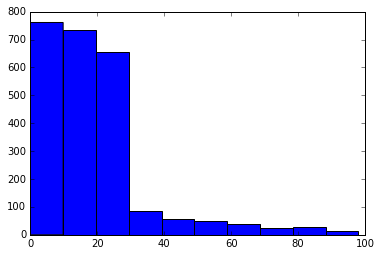

In [130]:
# plot histogram of differences b/w flood and GRACE-MASCON dates
plt.hist(df_flood_grace['Days from MASCON'])
plt.show()

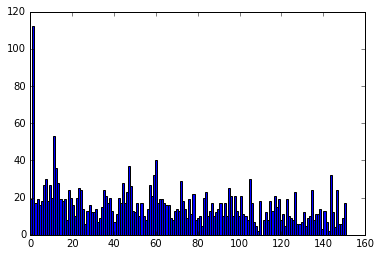

In [131]:
# plot histogram of GRACE MASCON time indexes of floods
plt.hist(df_flood_grace['MASCON Index'], bins = grace_time_datestr.size)
plt.show()

### Percentile Association

In [132]:
# create empty vectors
perc = np.zeros(df_flood_grace.shape[0])

# extract percentiles
for i in range(df_flood_grace.shape[0]):
    x = int(round(df_flood_grace['Centroid X GRACE'].iloc[i]))
    y = int(round(df_flood_grace['Centroid Y GRACE'].iloc[i]))
    time_ix = int(min_diff_ix[i])
    
    if x == 720:
        x = 719
    
    perc[i] = grace_lwe_perc_adj[y-1, x-1,  time_ix] 

In [133]:
df_flood_grace['GRACE %'] = perc

### Remove Floods Outside GRACE Land Mask 

In [134]:
# list of floods outsdie land mask
df_flood_grace_ocean = df_flood_grace[df_flood_grace['GRACE %'] == -1]
df_flood_grace_ocean[['Country','Centroid X GRACE', 'Centroid Y GRACE', 'MASCON Index']].head(5)

,Country,Centroid X GRACE,Centroid Y GRACE,MASCON Index
27,Fiji,355.8560,215.55080,150.0
44,Maldives,146.3784,180.28859,147.0
50,Bahamas,572.3352,135.01680,147.0
101,Chile,574.1576,268.20660,144.0
123,Angola,27.3622,197.63328,141.0


In [135]:
df_flood_grace_land = df_flood_grace[~(df_flood_grace['GRACE %'] == -1)]

# Plots

In [136]:
# set dataframe for plotting
df = df_flood_grace_land
df.shape

(2261, 22)

In [137]:
df.head(1)

,Register #,Began,Date Began,Ended,Duration in Days,Dead,Displaced,Damage (USD),Main cause,Severity *,...,Country,Other,Detailed Locations,Centroid X,Centroid Y,Centroid X GRACE,Centroid Y GRACE,Days from MASCON,MASCON Index,GRACE %
0,4356.0,8-May-16,08-May-16,11-May-16,4.0,0.0,0.0,NaN,Heavy Rain,1.0,...,China,0,South China; Guangzhou,112.952,24.7532,225.904,130.4936,52.0,151.0,100.0


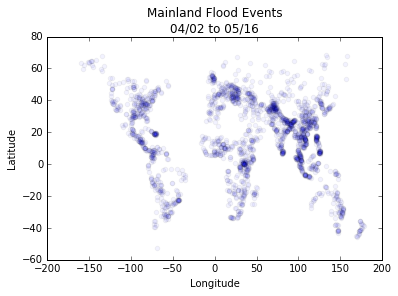

In [138]:
# frequency of floods across the world
x = df['Centroid X']
y = df['Centroid Y']

plt.scatter(x, y, alpha=0.05)
plt.title('Mainland Flood Events\n04/02 to 05/16')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig(dir_figures + 'floods_events.png')

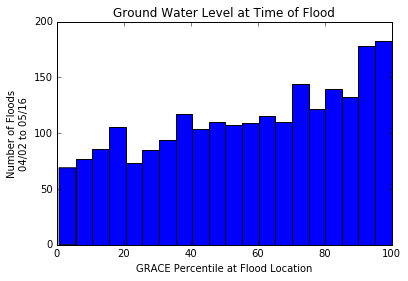

In [139]:
# GRACE levels during flood events
plt.hist(df['GRACE %'], bins=20)
plt.title('Ground Water Level at Time of Flood')
plt.xlabel('GRACE Percentile at Flood Location')
plt.ylabel('Number of Floods\n04/02 to 05/16')
plt.savefig(dir_figures + 'floods_GRACEPercentiles.png')